# Segmnetation Model Testing
This notebook aims to test various segmentation models to determine the best one for this project. Most of these models are available from the Segmentation Models - PyTorch (SMP) library. All models use the same transfer learning-based encoder (ResNet-101), as exploring various encoders is not feasible within the project's timeframe. Additionally, ResNet-101 has proven to be reliable and provides optimal results, as mentioned in the report.

A baseline model is created that does not use the ResNet-101 encoder, in order to highlight the significance of using a transfer learning-based encoder.

In [1]:
import os
import requests
import zipfile
import tarfile
import h5py
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar
from PIL import Image
from itertools import zip_longest
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from torchvision import models, transforms
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Functions

In [2]:
def load_images_from_dirs(directories):
    images = []
    for directory in directories:
        image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
        for file_name in image_files:
            file_path = os.path.join(directory, file_name) 
            img = Image.open(file_path)  
            img = np.array(img)  
            images.append(img)

    return images

    #This function, load_images_from_dirs, takes a list of directory paths as input. 
    #It searches for .png image files in each directory, opens them, converts them to numpy arrays, and stores them in a list. 
    #The function returns the list of images after processing all the directories.


In [4]:
class PixelLabelDatastore:
    def __init__(self, directories, class_names):
        self.class_names = class_names
        self.pixel_label_ids = np.arange(len(class_names))  # Sequential IDs: 0, 1, 2, ...
        self.pixel_labels = self.load_pixel_labels_from_dirs(directories)

    def load_pixel_labels_from_dirs(self, directories):
        pixel_labels = []
        for directory in directories:
            if not os.path.exists(directory):
                print(f"Directory does not exist: {directory}")
                continue

            hfive_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
            for file_name in hfive_files:
                file_path = os.path.join(directory, file_name)
                if not os.path.exists(file_path):
                    print(f"File does not exist: {file_path}")
                    continue

                try:
                    with h5py.File(file_path, 'r') as hfive_file:
                        if 'labels' in hfive_file:
                            label_data = hfive_file['labels'][:]
                            # Map pixel values to numeric indices
                            numeric_labels = self.map_pixel_values_to_indices(label_data)
                            # Map numeric indices to class names
                            class_name_labels = self.map_indices_to_class_names(numeric_labels)
                            pixel_labels.append({
                                'original': numeric_labels,      # Numeric indices (0, 1, 2, ...)
                                'mapped': class_name_labels      # Class names ("Noise", "NR", ...)
                            })
                        else:
                            print(f"'labels' dataset not found in {file_path}")
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

        return pixel_labels

    def map_pixel_values_to_indices(self, label_data):
        # Map raw pixel values to sequential class indices (0, 1, 2, ...)
        raw_to_sequential = {raw: idx for idx, raw in enumerate(
            np.floor(np.arange(len(self.class_names)) / (len(self.class_names) - 1) * 255).astype(int)
        )}
        # Assign the "Unknown" class index (e.g., 3) to any value not in raw_to_sequential
        return np.vectorize(lambda x: raw_to_sequential.get(x, len(self.class_names) - 1))(label_data)

    def map_indices_to_class_names(self, numeric_labels):
        # Map numeric indices (0, 1, 2, ...) to class names
        return np.vectorize(lambda idx: self.class_names[idx])(numeric_labels)

    def get_original_labels(self):
        # Collect and return all original numeric labels
        return [sample['original'] for sample in self.pixel_labels]

    def get_mapped_labels(self):
        # Collect and return all mapped class name labels
        return [sample['mapped'] for sample in self.pixel_labels]

#This class, PixelLabelDatastore, is designed to handle pixel-level labeled data for image segmentation. 
#It takes a list of directories and class names as input. The class loads pixel label data from .h5 files in the specified directories and 
#maps raw pixel values to class indices and class names.

#The load_pixel_labels_from_dirs method loads and processes label data from .h5 files in each directory.
#The map_pixel_values_to_indices method maps raw pixel values to sequential class indices.
#The map_indices_to_class_names method maps class indices to class names.
#The get_original_labels method retrieves the original numeric labels.
#The get_mapped_labels method retrieves the mapped class name labels.
        
#This class helps in organizing and mapping pixel-level labeled data for image segmentation tasks.

In [5]:
def helper_spec_sense_partition_data(imds, pxds, parts):
    """
    Partitions the image and pixel label datasets into training, validation, and test subsets.

    Parameters:
        imds (list): List of images (numpy arrays).
        pxds (list): List of pixel label datasets (numpy arrays).
        parts (list): A 1x3 list of percentages [train, validation, test].
                     The sum of the elements must equal 100.

    Returns:
        tuple:
        - imds_train, pxds_train: Training data subsets.
        - imds_val, pxds_val: Validation data subsets.
        - imds_test, pxds_test: Test data subsets.
    """
    # Validate input
    if len(parts) != 2 or sum(parts) != 100:
        raise ValueError("Parts must be a list of three elements summing to 100.")

    # Set random seed for reproducibility
    np.random.seed(0)

    # Shuffle indices
    num_files = len(imds)
    shuffled_indices = np.random.permutation(num_files)

    # Compute split indices
    num_train = int(num_files * parts[0] / 100)
    

    # Split data
    train_indices = shuffled_indices[:num_train]
    test_indices = shuffled_indices[num_train:]

    # Subset data
    imds_train = [imds[i] for i in train_indices]
    pxds_train = [pxds[i] for i in train_indices]

    imds_test = [imds[i] for i in test_indices]
    pxds_test = [pxds[i] for i in test_indices]

    # Stack all original labels and images into single NumPy arrays for efficient tensor creation
    labels_train = np.stack([sample['original'] for sample in pxds_train], axis=0)
    images_train = np.stack(imds_train, axis=0)

    labels_test = np.stack([sample['original'] for sample in pxds_test], axis=0)
    images_test = np.stack(imds_test, axis=0)

    # Return both partitioned and stacked datasets
    return images_train, labels_train, images_test, labels_test

#This function splits image and label data into training and test sets based on the percentages provided.

In [6]:
# Combine datasets for final use
def combine(imds, pxds):
    """Combine image and pixel label datasets."""
    return list(zip_longest(imds, pxds))

In [7]:
class ImageLabelDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

#This class, ImageLabelDataset, is used to store images and their labels for PyTorch.

#The __init__ method saves the images and labels when the dataset is created.
#The __len__ method returns the number of images in the dataset.
#The __getitem__ method gets an image and its label using an index.
        
#It helps in loading and using image-label pairs for training machine learning models in PyTorch.

In [1]:
def evaluate_model(model, val_loader, criterion, device, num_classes):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_preds = []  # To store all predictions
    all_labels = []  # To store all true labels

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, labels in tqdm(val_loader, desc='Validation', unit='batch'):
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect predictions and true labels for metric calculation
            preds = torch.argmax(outputs, dim=1)  # Get class predictions (shape: [batch_size, height, width])
            all_preds.append(preds.cpu().numpy())  # Store the predictions (move to CPU)
            all_labels.append(labels.cpu().numpy())  # Store the true labels (move to CPU)

    # Flatten all predictions and labels to calculate metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()  # Flatten predictions
    all_labels = np.concatenate(all_labels, axis=0).flatten()  # Flatten true labels

    # Calculate metrics
    accuracy = (all_preds == all_labels).mean()  # Pixel-level accuracy
    f1 = f1_score(all_labels, all_preds, average='weighted')  # F1 score (weighted)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    iou = jaccard_score(all_labels, all_preds, average='weighted')  # IoU using sklearn's jaccard_score

    # Compute average loss
    avg_loss = running_loss / len(val_loader)

    print(f"Validation Loss: {avg_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")

    return avg_loss, accuracy, f1, precision, recall, iou

#the function evaluates the model's performance on the validation data and calculates 
#important metrics like accuracy, F1 score, precision, recall, and IoU.

## Training Data directory and class setup

In [9]:
train_data_dir =[r'<insert your trainingData directory here>']
class_names = ["Noise", "NR", "LTE", "Unknown"]  # Define class names
num_classes = len(class_names)
pixel_label_ids = np.floor(np.arange(num_classes) / (num_classes - 1) * 255).astype(int)

## Image datastore
A function that loads all .png images in each specified directory.
For each image, it:
- Collects file names ending in .png.
- Opens the image, converts it to a NumPy array, and appends it to images.
- This function will return a list of images (in NumPy array form) stored in training_images.


In [10]:
training_images = load_images_from_dirs(train_data_dir)
print(f"Loaded {len(training_images)} images.")

Loaded 918 images.


In [11]:
# Load pixel labels using the updated PixelLabelDatastore class
pxds_truth_lte_nr = PixelLabelDatastore(train_data_dir, class_names)

# Print the number of datasets loaded (it will now reflect the number of samples)
print(f"Loaded {len(pxds_truth_lte_nr.pixel_labels)} sets of pixel labels.")

Loaded 918 sets of pixel labels.


## Train test datasplit

This code combines the image and label datasets for training and testing, and then prints the number of pairs in each set.

In [16]:
# Partition data
parts = [80, 20]  # 80% train, 20% test
imds_train, pxds_train, imds_test, pxds_test = helper_spec_sense_partition_data(
    training_images, pxds_truth_lte_nr.pixel_labels, parts)

In [17]:
cds_train = combine(imds_train, pxds_train)
cds_test = combine(imds_test, pxds_test)

print(f"Training set: {len(cds_train)} pairs")
print(f"Test set: {len(cds_test)} pairs")

Training set: 734 pairs
Test set: 184 pairs


## PyTorch tensors conversion

This code prepares the image and label data for training in PyTorch, normalizes the images, Permute Tensor Dimensions, and prints the tensor shapes for verification. 

In [18]:
# Now you can convert the stacked arrays to tensors
images_train_tensor = torch.tensor(imds_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(pxds_train, dtype=torch.long)

images_test_tensor = torch.tensor(imds_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(pxds_test, dtype=torch.long)

# Normalize images (after converting to tensors)
images_train_tensor = images_train_tensor / 255.0
images_train_tensor = images_train_tensor.permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

images_test_tensor = images_test_tensor / 255.0
images_test_tensor = images_test_tensor.permute(0, 3, 1, 2)

# Example of tensor shapes
print(f"Training images tensor shape: {images_train_tensor.shape}")
print(f"Training labels tensor shape: {labels_train_tensor.shape}")

print(f"Training images tensor shape: {images_test_tensor.shape}")
print(f"Training labels tensor shape: {labels_test_tensor.shape}")

Training images tensor shape: torch.Size([734, 3, 128, 128])
Training labels tensor shape: torch.Size([734, 128, 128])
Training images tensor shape: torch.Size([184, 3, 128, 128])
Training labels tensor shape: torch.Size([184, 128, 128])


## Data Loading

In [19]:
# Create datasets
train_dataset = ImageLabelDataset(images=images_train_tensor, labels=labels_train_tensor)
test_dataset = ImageLabelDataset(images=images_test_tensor, labels=labels_test_tensor)

# Create DataLoaders
batch_size = 16  # You can adjust the batch size based on your available memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Building custom model

In [20]:
class SimpleSemanticSegmentationNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSemanticSegmentationNet, self).__init__()

        # Encoder (Feature extraction with standard convolutions)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # No dilation
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling
        )

        # Multi-scale feature extraction (Alternative to ASPP)
        self.multi_scale = nn.ModuleList([
            nn.Conv2d(512, 512, kernel_size=1, padding=0),  # Smallest scale
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Medium scale
            nn.Conv2d(512, 512, kernel_size=5, padding=2)   # Largest scale
        ])

        # Decoder (Progressive upsampling with ConvTranspose2d)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, num_classes, kernel_size=(1, 1))  # Final classification layer
        )

    def forward(self, x):
        #print(f"Input shape: {x.shape}")  # Debugging input shape

        # Pass through the encoder
        x = self.encoder(x)
        #print(f"After encoder: {x.shape}")  # Debugging shape after encoder

        # Apply multi-scale convolutions and sum the outputs
        multi_scale_outputs = [conv(x) for conv in self.multi_scale]
        #for i, feat in enumerate(multi_scale_outputs):
            #print(f"Multi-scale feature {i} shape: {feat.shape}")

        multi_scale_features = torch.sum(torch.stack(multi_scale_outputs), dim=0)
        #print(f"After multi-scale fusion: {multi_scale_features.shape}")

        # Pass through the decoder
        x = self.decoder(multi_scale_features)
        #print(f"After decoder: {x.shape}")  # Debugging shape after decoder

        return x

# Define the network
num_classes = len(torch.unique(labels_train_tensor))  # Example number of classes
model = SimpleSemanticSegmentationNet(num_classes)

# Generate a dummy input tensor with shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 128, 128)  # Batch size = 1, 3 channels, 128x128 image

# Forward pass with debugging prints
output = model(dummy_input)

print(f"Output shape: {output.shape}")  # Final output shape

# Summary of the model
print(model)


Output shape: torch.Size([1, 3, 128, 128])
SimpleSemanticSegmentationNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

#### Model Description

Purpose:  Designed to classify each pixel of an image into one of the specified classes (Noise, NR, LTE, Unkown)

##### Encoder (Feature extraction):
- Purpose: Extract high-level features from the input image
- Operations:
    1. It consists of a series of convolutional layers (Conv2d) with ReLU activation functions and batch normalization (BatchNorm2d) to stabilize the training.
    2. After each convolutional layer, max-pooling (MaxPool2d) is applied to downsample the feature maps, reducing their spatial dimensions.
    3. The encoder captures spatial patterns and reduces the resolution of the input image step by step.
- The layers used are:
    1. Conv2d with increasing output channels: 64, 128, 256, 512.
    2. Max pooling at each stage to reduce the spatial resolution.
##### Multi-scale feature extraction:
- Purpose: Capture features at different scales to help the model recognize objects or patterns of varying sizes.
- Operations:
    1. Three convolutional layers (Conv2d) are applied with different kernel sizes: 1, 3, and 5. This allows the model to process the image at different receptive fields (scales).
    2. The outputs of these convolutions are summed together to combine multi-scale features, helping the network capture different spatial patterns effectively.
##### Decoder (Upsampling to original resolution):
- Purpose: Upsample the features to the original image resolution and prepare them for pixel-wise classification.
- Operations:
    1. It consists of a series of transposed convolution layers (ConvTranspose2d), each followed by ReLU and batch normalization.
    2. The transposed convolutions progressively upsample the feature maps, which increases the spatial dimensions back to the original size (i.e., from reduced resolution in the encoder).
    3. The final layer (Conv2d) produces the output with the number of channels equal to num_classes, which corresponds to the number of classes for semantic segmentation. This is the pixel-wise classification output.
##### Forward Pass:
1. The input image x passes through the encoder, which extracts high-level features.
2. Multi-scale convolutions are then applied on the encoder output, and the results are summed together.
3. The combined multi-scale features are passed through the decoder, which upsamples them and finally outputs a segmentation map of size (num_classes, height, width).
##### Example Usage:
Input: A dummy input tensor of shape (1, 3, 128, 128), where:
1 is the batch size.

3 is the number of input channels (RGB image).

128x128 is the height and width of the image.

Output: The output tensor will have a shape of (1, num_classes, 128, 128), where num_classes is the number of segmentation classes (4 in this case), and 128x128 is the output image size.

#### Common Terms:

##### Convolutional Layers (Conv2d):
Definition: Convolutional layers are the core building blocks of Convolutional Neural Networks (CNNs). They are used to automatically learn spatial hierarchies of features from input data (usually images).


Function: A convolutional layer applies a series of small filters (kernels) to the input image or feature map. These filters slide over the image, performing element-wise multiplication between the filter and the part of the image it is over, followed by summing the result. This produces a feature map.

##### ReLU Activation: 
After the convolution operation, an activation function like ReLU (Rectified Linear Unit) is applied. ReLU transforms negative values into zero and leaves positive values unchanged.

Why: This introduces non-linearity, helping the network learn complex patterns.
##### Batch Normalization (BatchNorm2d): 
This is a technique to normalize the activations of the neurons in each mini-batch. It adjusts and scales the output of the convolutional layer to reduce internal covariate shift.
Why: It speeds up training, makes the model more stable, and can lead to better performance.
#####  Max-Pooling (MaxPool2d):
Definition: Max-pooling is a downsampling operation used to reduce the spatial dimensions (height and width) of the input feature maps. It is typically applied after convolutional layers.

Function: Max-pooling selects the maximum value from a specific region (a window) of the feature map. For example, if the window size is 2x2, it will take the largest value from the 2x2 block and discard the rest.

Why: Max-pooling reduces the size of the feature maps, helping the network become more computationally efficient and invariant to small translations in the image (i.e., it becomes less sensitive to small shifts in the input).
##### Receptive Fields (Scales):
Definition: The receptive field refers to the region of the input image that a neuron in the network can "see" or "sense" as it processes the image.


Function: When a convolutional layer applies a filter, each neuron in the output feature map is looking at a small portion of the input image. This small portion is the receptive field.

eg:
- Small scale (1x1 filter): Looks at fine, detailed patterns.
- Medium scale (3x3 filter): Captures slightly broader patterns.
- Large scale (5x5 filter): Captures large patterns or structures.

Why: Using multiple receptive fields (scales) helps the network capture information at different levels of abstraction—small details, medium patterns, and large structures.

##### ConvTranspose2d (Deconvolution or Upsampling):
Definition: ConvTranspose2d is the reverse operation of a convolution. Instead of reducing the spatial dimensions like convolution does, it increases the spatial dimensions of the input feature map (also called upsampling or deconvolution).

Function: It applies a filter to the input but performs an operation that effectively "upsamples" the feature map. This is commonly used in decoder sections of segmentation networks to restore the spatial resolution after downsampling in the encoder.

Why: The purpose is to reconstruct the high-resolution output (like a segmentation mask) from the downsampled features extracted in the encoder part of the network.

### Define loss function and optimiser

In [21]:
# Set device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleSemanticSegmentationNet(num_classes).to(device)


# CrossEntropyLoss for segmentation tasks
criterion = nn.CrossEntropyLoss()

# Adam optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
num_epochs = 10  # Set the number of epochs for training

# Initialize a list to store accuracy for each epoch
accuracy_per_epoch_baseline = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_preds = []  # To store all predictions
    all_labels = []  # To store all true labels
    
    # Wrap the train_loader with tqdm for a progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as tepoch:
        for images, labels in tepoch:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Collect predictions and true labels for metric calculation
            preds = torch.argmax(outputs, dim=1)  # Get class predictions (shape: [batch_size, height, width])
            
            all_preds.append(preds.cpu().numpy())  # Store the predictions (move to CPU)
            all_labels.append(labels.cpu().numpy())  # Store the true labels (move to CPU)

            # Update progress bar with loss info
            tepoch.set_postfix(loss=loss.item())

    # Flatten all predictions and labels to calculate metrics
    all_preds = np.concatenate(all_preds, axis=0)  # Concatenate predictions
    all_labels = np.concatenate(all_labels, axis=0)  # Concatenate true labels

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()  # Pixel-level accuracy
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='weighted')  # F1 score (weighted)
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='weighted', zero_division=1)
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='weighted', zero_division=1)

    # Store accuracy for this epoch
    accuracy_per_epoch_baseline.append(accuracy)

    # Print statistics every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_baseline}")


Epoch 1/10: 100%|████████████████████████████████████████████████████████| 46/46 [00:09<00:00,  5.00batch/s, loss=1.06]


Epoch [1/10], Loss: 1.0891, Accuracy: 0.4032, F1 Score: 0.3826, Precision: 0.3792, Recall: 0.4032


Epoch 2/10: 100%|████████████████████████████████████████████████████████| 46/46 [00:08<00:00,  5.27batch/s, loss=1.07]


Epoch [2/10], Loss: 1.0494, Accuracy: 0.4411, F1 Score: 0.3798, Precision: 0.4002, Recall: 0.4411


Epoch 3/10: 100%|████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.87batch/s, loss=1.03]


Epoch [3/10], Loss: 1.0321, Accuracy: 0.4682, F1 Score: 0.4020, Precision: 0.4113, Recall: 0.4682


Epoch 4/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.60batch/s, loss=0.991]


Epoch [4/10], Loss: 1.0105, Accuracy: 0.4963, F1 Score: 0.4353, Precision: 0.4105, Recall: 0.4963


Epoch 5/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.24batch/s, loss=1]


Epoch [5/10], Loss: 0.9923, Accuracy: 0.5171, F1 Score: 0.4568, Precision: 0.4793, Recall: 0.5171


Epoch 6/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.31batch/s, loss=0.983]


Epoch [6/10], Loss: 0.9731, Accuracy: 0.5285, F1 Score: 0.4741, Precision: 0.4943, Recall: 0.5285


Epoch 7/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.03batch/s, loss=0.955]


Epoch [7/10], Loss: 0.9529, Accuracy: 0.5432, F1 Score: 0.5141, Precision: 0.5239, Recall: 0.5432


Epoch 8/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.23batch/s, loss=0.883]


Epoch [8/10], Loss: 0.9079, Accuracy: 0.5763, F1 Score: 0.5639, Precision: 0.5681, Recall: 0.5763


Epoch 9/10: 100%|███████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.24batch/s, loss=0.764]


Epoch [9/10], Loss: 0.8437, Accuracy: 0.6135, F1 Score: 0.6056, Precision: 0.6097, Recall: 0.6135


Epoch 10/10: 100%|██████████████████████████████████████████████████████| 46/46 [00:06<00:00,  7.23batch/s, loss=0.767]


Epoch [10/10], Loss: 0.8023, Accuracy: 0.6284, F1 Score: 0.6217, Precision: 0.6251, Recall: 0.6284

Accuracy for each epoch: [0.40317604002575785, 0.4410934240356778, 0.468208915855969, 0.49632425334213215, 0.5170578293969261, 0.5285320230011069, 0.5431517723145862, 0.5763487439064628, 0.6134922952677964, 0.6283780547513624]


This training loop trains a model for 10 epochs, where in each epoch, it performs a forward pass on the training data, computes the loss, and updates the model weights using backpropagation and the optimizer. It tracks predictions and true labels to calculate metrics such as accuracy, F1 score, precision, and recall after each epoch. The loop also displays a progress bar using tqdm and prints out the loss, accuracy, F1 score, precision, and recall at the end of each epoch. Additionally, it stores the accuracy for each epoch and prints the accuracy values at the end of training to show the model's performance over time.

In [23]:
  # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device, num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.01batch/s]


Validation Loss: 0.8036, Accuracy: 0.6274, F1 Score: 0.6220, Precision: 0.6230, Recall: 0.6274, IoU: 0.4561


(0.8036289612452189,
 0.6274112203846807,
 0.6219762855237922,
 0.6230157876081306,
 0.6274112203846807,
 0.45608901059323104)

The model without any pretrained encoder/backbone has achieved subpar results:

Accurcary: 62.74%

F1 score: 62.2%

IoU score: 45.61%

## PSPnet - SMP
PSPNet (Pyramid Scene Parsing Network) is a deep learning model designed for semantic segmentation, introduced by Zhao et al. in 2017. It enhances segmentation accuracy by using global context information, which is crucial for understanding objects and their relationships within a scene.

ResNet Backbone: Extracts deep hierarchical features from the image.

Pyramid Pooling Module (PPM): Captures multi-scale context information.

Final Feature Fusion: Combines global and local information.

Pixel-wise Prediction: Generates final segmentation map.

In [26]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize PSPNet with ResNet101 encoder
num_classes = len(torch.unique(labels_train_tensor))  # Ensure this is correct
model = smp.PSPNet(
    encoder_name="resnet101", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=num_classes  # Number of output classes
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss() if binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
num_epochs = 10

# Initialize a list to store accuracy for each epoch
accuracy_per_epoch_pspnet = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Shape: (batch, num_classes, height, width)

        # Compute loss (CE expects labels as (batch, H, W), not one-hot)
        loss = criterion(outputs, labels.long())  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions (argmax over classes)
        preds = torch.argmax(outputs, dim=1)  # Shape: (batch, H, W)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_pspnet.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_pspnet}")


Epoch 1/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 15.51it/s, loss=1.02]


Epoch [1/10], Loss: 1.1105, Accuracy: 0.4660, F1 Score: 0.4490, Precision: 0.4433, Recall: 0.4660


Epoch 2/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 16.54it/s, loss=0.99]


Epoch [2/10], Loss: 0.9711, Accuracy: 0.5463, F1 Score: 0.5288, Precision: 0.5279, Recall: 0.5463


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.11it/s, loss=0.816]


Epoch [3/10], Loss: 0.9130, Accuracy: 0.5769, F1 Score: 0.5639, Precision: 0.5648, Recall: 0.5769


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.89it/s, loss=0.835]


Epoch [4/10], Loss: 0.8430, Accuracy: 0.6151, F1 Score: 0.6065, Precision: 0.6097, Recall: 0.6151


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.72it/s, loss=0.721]


Epoch [5/10], Loss: 0.7661, Accuracy: 0.6581, F1 Score: 0.6533, Precision: 0.6559, Recall: 0.6581


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.99it/s, loss=0.709]


Epoch [6/10], Loss: 0.6848, Accuracy: 0.6974, F1 Score: 0.6945, Precision: 0.6951, Recall: 0.6974


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.06it/s, loss=0.605]


Epoch [7/10], Loss: 0.6142, Accuracy: 0.7301, F1 Score: 0.7281, Precision: 0.7283, Recall: 0.7301


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.88it/s, loss=0.501]


Epoch [8/10], Loss: 0.5441, Accuracy: 0.7634, F1 Score: 0.7622, Precision: 0.7624, Recall: 0.7634


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 17.88it/s, loss=0.428]


Epoch [9/10], Loss: 0.5115, Accuracy: 0.7764, F1 Score: 0.7753, Precision: 0.7750, Recall: 0.7764


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 18.40it/s, loss=0.399]


Epoch [10/10], Loss: 0.4894, Accuracy: 0.7862, F1 Score: 0.7855, Precision: 0.7851, Recall: 0.7862

Accuracy for each epoch: [0.4660022538104564, 0.5463161208649098, 0.5768963140752725, 0.6151251935828934, 0.6581449170853202, 0.6973909383248893, 0.7301165089620232, 0.7634252397500851, 0.7764000333947122, 0.786172061265327]


In [27]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.59batch/s]


Validation Loss: 0.5110, Accuracy: 0.7750, F1 Score: 0.7720, Precision: 0.7755, Recall: 0.7750, IoU: 0.6325


(0.5110130459070206,
 0.7750207652216372,
 0.7720119945911434,
 0.7755480414393475,
 0.7750207652216372,
 0.632486476542045)

PSPNet has achieved better performance compared to the baseline model, achieving the following score:

Accuracy: 77.5%

F1: 77.2%

IoU: 63.25%

The perfomance has increased by a great amount, especially IoU, jumping up to 20%

## U-net 
U-Net is a deep learning model designed for semantic segmentation, particularly for medical image analysis. It was introduced by Olaf Ronneberger et al. in 2015 and is known for its U-shaped architecture that enables precise pixel-wise classification. U-Net is a powerful yet efficient model for semantic segmentation, particularly when working with limited labeled data. It is widely used in medical imaging, remote sensing, and autonomous systems.

U-Shaped Architecture → Symmetric encoder-decoder structure.

Skip Connections → Helps retain spatial information lost in down-sampling.

Fully Convolutional → No fully connected layers, allowing variable input sizes.

Efficient Training → Works well on small datasets using data augmentation.

Pixel-Wise Classification → Produces high-resolution segmentation maps.

In [24]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize U-Net with ResNet101 encoder
num_classes = len(torch.unique(labels_train_tensor))  # Ensure this is correct
model = smp.Unet(
    encoder_name="resnet101", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=num_classes  # Number of output classes
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss() if binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
num_epochs = 10

# Initialize a list to store accuracy for each epoch
accuracy_per_epoch_unet = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Shape: (batch, num_classes, height, width)

        # Compute loss (CE expects labels as (batch, H, W), not one-hot)
        loss = criterion(outputs, labels.long())  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions (argmax over classes)
        preds = torch.argmax(outputs, dim=1)  # Shape: (batch, H, W)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_unet.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_unet}")


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:08<00:00,  5.54it/s, loss=0.873]


Epoch [1/10], Loss: 1.0145, Accuracy: 0.4934, F1 Score: 0.4862, Precision: 0.4831, Recall: 0.4934


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.25it/s, loss=0.657]


Epoch [2/10], Loss: 0.7357, Accuracy: 0.6748, F1 Score: 0.6686, Precision: 0.6669, Recall: 0.6748


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.36it/s, loss=0.518]


Epoch [3/10], Loss: 0.5776, Accuracy: 0.7567, F1 Score: 0.7532, Precision: 0.7535, Recall: 0.7567


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.41it/s, loss=0.393]


Epoch [4/10], Loss: 0.4403, Accuracy: 0.8298, F1 Score: 0.8284, Precision: 0.8292, Recall: 0.8298


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.42it/s, loss=0.477]


Epoch [5/10], Loss: 0.3771, Accuracy: 0.8550, F1 Score: 0.8540, Precision: 0.8548, Recall: 0.8550


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.35it/s, loss=0.258]


Epoch [6/10], Loss: 0.3163, Accuracy: 0.8784, F1 Score: 0.8778, Precision: 0.8782, Recall: 0.8784


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.30it/s, loss=0.261]


Epoch [7/10], Loss: 0.2712, Accuracy: 0.8965, F1 Score: 0.8960, Precision: 0.8964, Recall: 0.8965


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.27it/s, loss=0.248]


Epoch [8/10], Loss: 0.2502, Accuracy: 0.9027, F1 Score: 0.9023, Precision: 0.9026, Recall: 0.9027


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.42it/s, loss=0.202]


Epoch [9/10], Loss: 0.2216, Accuracy: 0.9147, F1 Score: 0.9145, Precision: 0.9146, Recall: 0.9147


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.41it/s, loss=0.161]


Epoch [10/10], Loss: 0.1946, Accuracy: 0.9252, F1 Score: 0.9249, Precision: 0.9251, Recall: 0.9252

Accuracy for each epoch: [0.4933918217547258, 0.6747542129225562, 0.7566816033719346, 0.8298413850955807, 0.8549743153418767, 0.8783813809179155, 0.8965177198196952, 0.9027096283208447, 0.9147175053484758, 0.9251550991463726]


In [25]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.14batch/s]


Validation Loss: 0.2330, Accuracy: 0.9071, F1 Score: 0.9063, Precision: 0.9076, Recall: 0.9071, IoU: 0.8295


(0.23303092395265898,
 0.9070583841075068,
 0.9062790955431985,
 0.9075957084519297,
 0.9070583841075068,
 0.8294973969133668)

U-Net has achieved the best score so far, close to 90% for everything except IoU, which was at 83%.

## DeepLabV3+

DeepLabV3+ is a state-of-the-art deep learning architecture specifically designed for semantic segmentation, which involves assigning a class label to every pixel in an image. It builds on the DeepLabV3 architecture by adding a decoder module to improve the segmentation results, especially along object boundaries.

Components of the Model:

1. Backbone:
Extracts hierarchical features from the input image. This is the ResNet101 part of the model.
Outputs feature maps at various scales and encodes spatial and contextual information.
2. ASPP (Atrous Spatial Pyramid Pooling):
Captures multi-scale context by applying dilated convolutions at different rates.
Improves the ability to recognize objects at different scales.
3. Decoder:
Upsamples the output of the ASPP to the original image resolution.
Refines the segmentation map for better accuracy and localization of boundaries.
4. Model Forward Pass:
Input goes through the backbone (ResNet101) to extract features.
Features are passed to the ASPP module for multi-scale context extraction.
The decoder upsamples the processed features back to the input size and outputs the segmentation map.
5. Training Loop:
The model is trained using a CrossEntropyLoss function, which is appropriate for multi-class classification tasks like semantic segmentation.
An Adam optimizer is used for gradient updates.
During each epoch:
The model processes batches of images.
Predictions are made, and the loss is computed based on the difference between predictions and ground truth labels.
The optimizer updates the model's weights to minimize the loss.

In [31]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()

        # Load pretrained DeepLabV3+ with ResNet101 backbone
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True, output_stride=8)

        # Modify the classifier (final layer) to match num_classes
        in_channels = self.model.classifier[4].in_channels  # Get input channels of last layer
        self.model.classifier[4] = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)['out']  # Use built-in forward pass

# Initialize the model
num_classes = len(torch.unique(labels_train_tensor))  # Set this to the number of classes
model = DeepLabV3Plus(num_classes=num_classes)

# Print the model architecture
#print(model)

# Example forward pass with a random tensor (batch_size=16, channels=3, height=128, width=128)
inputs = torch.randn(16, 3, 128, 128)  # Example input
outputs = model(inputs)
print(outputs.size())  # Should be (batch_size, num_classes, height, width)


C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mathu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([16, 3, 128, 128])


In [32]:
num_classes = len(torch.unique(labels_train_tensor))

num_epochs = 10  # Set the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3Plus(num_classes=num_classes).to(device)

accuracy_per_epoch_deeplab = []

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)  # Progress bar

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get the predictions (class with highest score)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics after each epoch
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='weighted')
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_deeplab.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_deeplab}")


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:15<00:00,  3.02it/s, loss=0.746]


Epoch [1/10], Loss: 0.9059, Accuracy: 0.5695, F1 Score: 0.5781, Precision: 0.6144, Recall: 0.5695


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:13<00:00,  3.48it/s, loss=0.431]


Epoch [2/10], Loss: 0.5225, Accuracy: 0.7926, F1 Score: 0.7911, Precision: 0.7918, Recall: 0.7926


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.57it/s, loss=0.285]


Epoch [3/10], Loss: 0.3527, Accuracy: 0.8694, F1 Score: 0.8688, Precision: 0.8692, Recall: 0.8694


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.59it/s, loss=0.257]


Epoch [4/10], Loss: 0.2775, Accuracy: 0.8999, F1 Score: 0.8996, Precision: 0.8999, Recall: 0.8999


Epoch 5/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.60it/s, loss=0.207]


Epoch [5/10], Loss: 0.2435, Accuracy: 0.9120, F1 Score: 0.9117, Precision: 0.9118, Recall: 0.9120


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.55it/s, loss=0.189]


Epoch [6/10], Loss: 0.2210, Accuracy: 0.9188, F1 Score: 0.9186, Precision: 0.9187, Recall: 0.9188


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.61it/s, loss=0.204]


Epoch [7/10], Loss: 0.1914, Accuracy: 0.9313, F1 Score: 0.9312, Precision: 0.9312, Recall: 0.9313


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:13<00:00,  3.53it/s, loss=0.157]


Epoch [8/10], Loss: 0.1723, Accuracy: 0.9382, F1 Score: 0.9381, Precision: 0.9382, Recall: 0.9382


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.58it/s, loss=0.203]


Epoch [9/10], Loss: 0.1550, Accuracy: 0.9452, F1 Score: 0.9451, Precision: 0.9451, Recall: 0.9452


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:12<00:00,  3.62it/s, loss=0.133]


Epoch [10/10], Loss: 0.1339, Accuracy: 0.9530, F1 Score: 0.9529, Precision: 0.9529, Recall: 0.9530

Accuracy for each epoch: [0.5695409956680006, 0.7925800042841025, 0.8694255943194397, 0.8999235480617762, 0.9119508831637432, 0.9188151762336086, 0.9312670964960831, 0.9382196161337705, 0.9451741314713896, 0.9529946142711172]


In [33]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.91batch/s]


Validation Loss: 0.1954, Accuracy: 0.9261, F1 Score: 0.9259, Precision: 0.9262, Recall: 0.9261, IoU: 0.8624


(0.19538290922840437,
 0.9261053334111753,
 0.9258686910007115,
 0.9261882590679278,
 0.9261053334111753,
 0.8623812302249934)

DeepLabV3+ has performed marginally better than U-Net, with a 2% increase in all metrics.

## Segformer
SegFormer (Segmenter with Transformer) is a semantic segmentation model that combines the strengths of Transformers and CNNs, introduced by Xie et al. in 2021. It is known for being lightweight, efficient, and highly accurate while requiring no complex post-processing like dilated convolutions or hand-designed decoder structures.

 Hierarchical Transformer Encoder → Captures multi-scale features.
 
 Lightweight MLP Decoder → Simple yet effective segmentation head.
 
 No Positional Encoding Needed → Unlike ViTs, it learns spatial relationships directly.
 
 Efficient & Fast → Suitable for real-time applications.
 
 State-of-the-Art Performance → Competes with DeepLabV3+, U-Net, etc.

In [38]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize PSPNet with ResNet101 encoder
num_classes = len(torch.unique(labels_train_tensor))  # Ensure this is correct
model = smp.Segformer(
    encoder_name="resnet101", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=num_classes  # Number of output classes
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss() if binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Number of epochs
num_epochs = 10

accuracy_per_epoch_segformer = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Shape: (batch, num_classes, height, width)

        # Compute loss (CE expects labels as (batch, H, W), not one-hot)
        loss = criterion(outputs, labels.long())  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions (argmax over classes)
        preds = torch.argmax(outputs, dim=1)  # Shape: (batch, H, W)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Compute metrics
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()

    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Store accuracy for this epoch
    accuracy_per_epoch_segformer.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_segformer}")


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.43it/s, loss=0.839]


Epoch [1/10], Loss: 1.0471, Accuracy: 0.4957, F1 Score: 0.5023, Precision: 0.5154, Recall: 0.4957


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.58it/s, loss=0.473]


Epoch [2/10], Loss: 0.6323, Accuracy: 0.7217, F1 Score: 0.7178, Precision: 0.7174, Recall: 0.7217


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.73it/s, loss=0.424]


Epoch [3/10], Loss: 0.4700, Accuracy: 0.7950, F1 Score: 0.7931, Precision: 0.7933, Recall: 0.7950


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.63it/s, loss=0.395]


Epoch [4/10], Loss: 0.3860, Accuracy: 0.8343, F1 Score: 0.8333, Precision: 0.8332, Recall: 0.8343


Epoch 5/10: 100%|███████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.45it/s, loss=0.29]


Epoch [5/10], Loss: 0.3303, Accuracy: 0.8589, F1 Score: 0.8583, Precision: 0.8584, Recall: 0.8589


Epoch 6/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.56it/s, loss=0.307]


Epoch [6/10], Loss: 0.2963, Accuracy: 0.8744, F1 Score: 0.8738, Precision: 0.8740, Recall: 0.8744


Epoch 7/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.43it/s, loss=0.239]


Epoch [7/10], Loss: 0.2595, Accuracy: 0.8897, F1 Score: 0.8894, Precision: 0.8895, Recall: 0.8897


Epoch 8/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.57it/s, loss=0.238]


Epoch [8/10], Loss: 0.2534, Accuracy: 0.8929, F1 Score: 0.8927, Precision: 0.8927, Recall: 0.8929


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.48it/s, loss=0.186]


Epoch [9/10], Loss: 0.2200, Accuracy: 0.9070, F1 Score: 0.9067, Precision: 0.9068, Recall: 0.9070


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 46/46 [00:07<00:00,  6.45it/s, loss=0.202]


Epoch [10/10], Loss: 0.2076, Accuracy: 0.9126, F1 Score: 0.9124, Precision: 0.9124, Recall: 0.9126


NameError: name 'accuracy_per_epoch_deeplab_segformer' is not defined

In [39]:
# After training, you can print the accuracies for all epochs
print(f"\nAccuracy for each epoch: {accuracy_per_epoch_segformer}")


Accuracy for each epoch: [0.49572679067502556, 0.7217050495199676, 0.7950437790041723, 0.8342756640358907, 0.8589306241485014, 0.874397381774736, 0.8896698912742678, 0.89290849649289, 0.9070071186616571, 0.9126445551983992]


In [40]:
 # Evaluate on the validation dataset
evaluate_model(model, test_loader, criterion, device,num_classes)

Validation: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.55batch/s]


Validation Loss: 0.3050, Accuracy: 0.8688, F1 Score: 0.8678, Precision: 0.8687, Recall: 0.8688, IoU: 0.7685


(0.30500008290012676,
 0.8687701017960258,
 0.8678205428403105,
 0.8686696833279604,
 0.8687701017960258,
 0.7685133468761146)

Segformer has outperfromed the baseline and PSPNet model, but did not meet U-Net or DeepLabV3+ level performance. This may be due to its architecture being too simple to handle the complex segmentation task. 

## model comparision

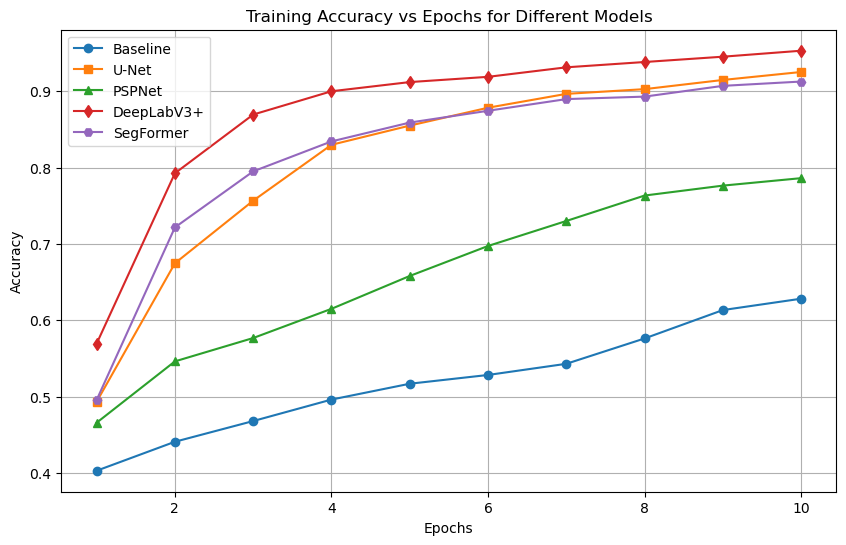

In [3]:
# Epoch range (10 epochs in your case)
epochs = list(range(1, 11))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model's accuracy
plt.plot(epochs, accuracy_per_epoch_baseline, label='Baseline', marker='o')
plt.plot(epochs, accuracy_per_epoch_unet, label='U-Net', marker='s')
plt.plot(epochs, accuracy_per_epoch_pspnet, label='PSPNet', marker='^')
#plt.plot(epochs, accuracy_per_epoch_fcn, label='FCN', marker='x')
plt.plot(epochs, accuracy_per_epoch_deeplab, label='DeepLabV3+', marker='d')
#plt.plot(epochs, accuracy_per_epoch_deeplab_trans, label='DeepLabV3+ Trans', marker='p')
plt.plot(epochs, accuracy_per_epoch_segformer, label='SegFormer', marker='H')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs for Different Models')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


From the plot, DeepLabV3+ has performed distinctively better than the other models. Hence, it will be used as the primary  model for this project.